In [2]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

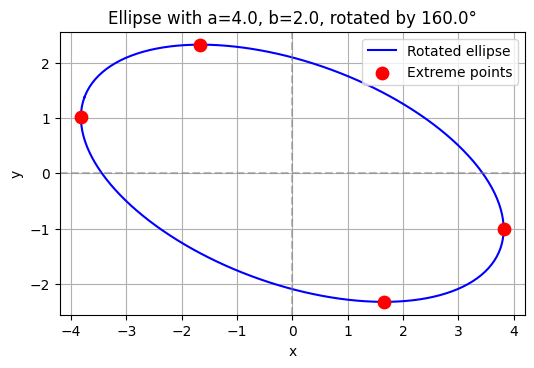

In [8]:

def ellipse_parametric(a, b, theta_deg, num_pts=300):
    """
    Returns arrays (x_vals, y_vals) parameterizing the ellipse
    of semi-axes a,b, rotated by theta_deg, centered at the origin.
    """
    theta = np.radians(theta_deg)
    
    # Parametrize unrotated ellipse
    t = np.linspace(0, 2*np.pi, num_pts)
    x_prim = a * np.cos(t)
    y_prim = b * np.sin(t)
    
    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    # Rotate points
    xy_rot = R @ np.vstack((x_prim, y_prim))  # shape (2, num_pts)
    return xy_rot[0], xy_rot[1]

def ellipse_extremes_analytic(a, b, theta_deg):
    """
    Returns the four extreme points on the rotated ellipse using
    closed-form expressions:
      (xR, yR) -> rightmost
      (xL, yL) -> leftmost
      (xT, yT) -> topmost
      (xB, yB) -> bottommost
    """
    theta = np.radians(theta_deg)

    # Rightmost (max x)
    xR = +np.sqrt(a*a * np.cos(theta)**2 + b*b * np.sin(theta)**2)
    yR = ((a*a - b*b) * np.sin(theta) * np.cos(theta)) / xR
    
    # Leftmost (min x)
    xL = -xR
    yL = -yR
    
    # Topmost (max y)
    yT = +np.sqrt(a*a * np.sin(theta)**2 + b*b * np.cos(theta)**2)
    xT = ((a*a - b*b) * np.sin(theta) * np.cos(theta)) / yT
    
    # Bottommost (min y)
    yB = -yT
    xB = -xT
    
    return (xR, yR), (xL, yL), (xT, yT), (xB, yB)

def plot_rotated_ellipse_analytic_extremes(a, b, theta_deg):
    """
    Plots the rotated ellipse (a,b,theta_deg) and marks
    the four extreme points using the closed-form formulas.
    """
    # 1) Generate the ellipse points for plotting
    x_vals, y_vals = ellipse_parametric(a, b, theta_deg)
    
    # 2) Compute the four extreme points analytically
    (xR, yR), (xL, yL), (xT, yT), (xB, yB) = ellipse_extremes_analytic(a, b, theta_deg)
    
    # 3) Plot
    plt.figure(figsize=(6,6))
    plt.plot(x_vals, y_vals, 'b-', label="Rotated ellipse")
    
    # Plot extreme points in red
    plt.scatter([xR, xL, xT, xB],
                [yR, yL, yT, yB],
                color='red', s=80, zorder=3,
                label="Extreme points")
    
    # Axes lines
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.gca().set_aspect('equal', 'box')
    plt.title(f"Ellipse with a={a}, b={b}, rotated by {theta_deg}°")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

a = 4.0
b = 2.0
theta_deg = 160.0
plot_rotated_ellipse_analytic_extremes(a, b, theta_deg)


Ok now I need to produce a plot that moves this oval around and keeps track of where its extreme boundaries are on the x,y plane. Let's make that happen

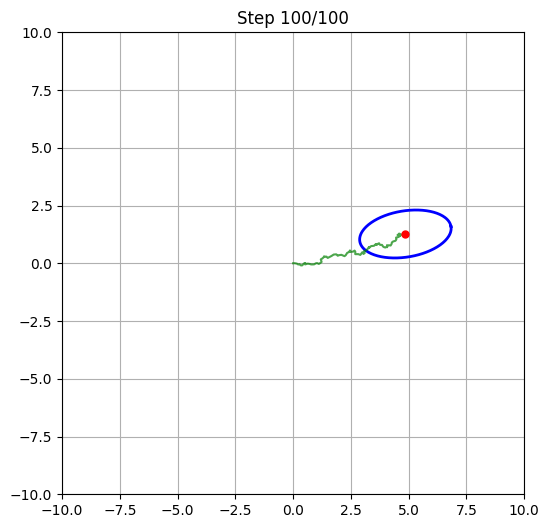

In [105]:
class BrownianSwimmer:
    """
    Represents a single oval (ellipse) that moves under Brownian-like dynamics
    while leaving a trace of its central position.
    """

    def __init__(self, a=2.0, b=1.0,
                 x_init=0.0, y_init=0.0, theta_init=0.0,
                 U=1.0, D=0.01, n_points=200):
        """
        Parameters
        ----------
        a, b         : float
            Semi-axes defining the oval (ellipse) in local coordinates.
        x_init, y_init : float
            Initial position of the center.
        theta_init   : float
            Initial orientation in radians.
        U, D         : float
            Drift (U) and diffusion (D) parameters for the Brownian dynamics.
        n_points     : int
            Number of points to represent the ellipse boundary.
        """
        self.a = a
        self.b = b
        self.x = x_init
        self.y = y_init
        self.theta = theta_init

        self.U = U
        self.D = D
        self.n_points = n_points

        # Precompute local shape (x', y') of the oval
        t = np.linspace(0, 2 * np.pi, n_points)
        self.x_prim = self.a * np.cos(t)
        self.y_prim = self.b * np.sin(t)

        # Store past trajectory
        self.trace_x = [self.x]
        self.trace_y = [self.y]

    def step(self, dt):
        """
        Update the position and orientation using Brownian increments.
        """
        xi1, xi2, xi3 = np.random.randn(3)

        self.x += (self.U * np.cos(self.theta) * dt
                   + np.sqrt(2*self.D*dt)*xi1)
        self.y += (self.U * np.sin(self.theta) * dt
                   + np.sqrt(2*self.D*dt)*xi2)
        self.theta += np.sqrt(2*self.D*dt) * xi3

        # Store new position in the trajectory trace
        self.trace_x.append(self.x)
        self.trace_y.append(self.y)

    def get_global_coords(self):
        """
        Compute the global coordinates of the ellipse after rotation and translation.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)
        x_rot = c * self.x_prim - s * self.y_prim
        y_rot = s * self.x_prim + c * self.y_prim
        return x_rot + self.x, y_rot + self.y

    def run(self, steps=100, dt=0.1, xlim=(-5, 5), ylim=(-5, 5), pause_time=0.05):
        """
        Runs a live animation in a Jupyter Notebook, updating a single plot.
        Leaves a trace of the moving central point.
        
        Parameters
        ----------
        steps      : int
            Number of time steps.
        dt         : float
            Time-step size.
        xlim, ylim : tuple
            Fixed axis limits for the animation.
        pause_time : float
            Time to pause in each loop iteration (seconds),
            creating the animation effect.
        """
        fig, ax = plt.subplots(figsize=(6, 6))

        for step_i in range(steps):
            self.step(dt)
            xg, yg = self.get_global_coords()

            # Clear output and refresh plot
            clear_output(wait=True)
            ax.clear()
            ax.plot(xg, yg, 'b-', lw=2)  # Draw the oval
            ax.plot(self.trace_x, self.trace_y, 'g-', lw=1.5, alpha=0.7)  # Draw trajectory
            ax.plot(self.x, self.y, 'ro', ms=5)  # Mark current position

            # Axes settings
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Step {step_i+1}/{steps}")
            ax.grid(True)

            display(fig)  # Show updated plot

        plt.close(fig)  # Close figure after animation completes




swimmer = BrownianSwimmer(a=2.0, b=1.0, U=1.0, D=0.02)
swimmer.run(steps=100, dt=0.05, xlim=(-10, 10), ylim=(-10, 10))


Now let's add marking the maximal and minimal x and y points along the x and y axis to this

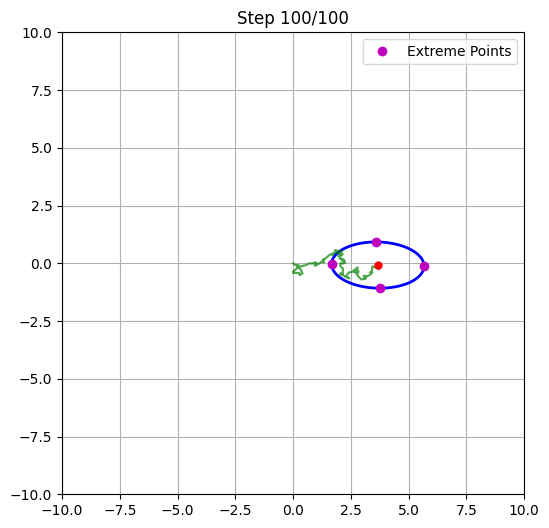

In [6]:
class BrownianSwimmer:
    """
    Represents a single oval (ellipse) that moves under Brownian-like dynamics
    while leaving a trace of its central position.
    """

    def __init__(self, a=2.0, b=1.0,
                 x_init=0.0, y_init=0.0, theta_init=0.0,
                 U=1.0, D=0.01, n_points=200):
        """
        Parameters
        ----------
        a, b         : float
            Semi-axes defining the oval (ellipse) in local coordinates.
        x_init, y_init : float
            Initial position of the center.
        theta_init   : float
            Initial orientation in radians.
        U, D         : float
            Drift (U) and diffusion (D) parameters for the Brownian dynamics.
        n_points     : int
            Number of points to represent the ellipse boundary.
        """
        self.a = a
        self.b = b
        self.x = x_init
        self.y = y_init
        self.theta = theta_init

        self.U = U
        self.D = D
        self.n_points = n_points

        # Precompute local shape (x', y') of the oval
        t = np.linspace(0, 2 * np.pi, n_points)
        self.x_prim = self.a * np.cos(t)
        self.y_prim = self.b * np.sin(t)

        # Store past trajectory
        self.trace_x = [self.x]
        self.trace_y = [self.y]

    def step(self, dt):
        """
        Update the position and orientation using Brownian increments.
        """
        xi1, xi2, xi3 = np.random.randn(3)

        self.x += (self.U * np.cos(self.theta) * dt
                   + np.sqrt(2*self.D*dt)*xi1)
        self.y += (self.U * np.sin(self.theta) * dt
                   + np.sqrt(2*self.D*dt)*xi2)
        self.theta += np.sqrt(2*self.D*dt) * xi3

        # Store new position in the trajectory trace
        self.trace_x.append(self.x)
        self.trace_y.append(self.y)

    def get_global_coords(self):
        """
        Compute the global coordinates of the ellipse after rotation and translation.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)
        x_rot = c * self.x_prim - s * self.y_prim
        y_rot = s * self.x_prim + c * self.y_prim
        return x_rot + self.x, y_rot + self.y

    def get_extreme_points(self):
        """
        Computes the four extreme points (leftmost, rightmost, topmost, bottommost)
        analytically for the rotated ellipse.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)

        # Compute rightmost (max X) and leftmost (min X)
        denom_x = np.sqrt(self.a**2 * c**2 + self.b**2 * s**2)
        x_right = self.x + denom_x
        x_left = self.x - denom_x
        y_right = self.y + ((self.a**2 - self.b**2) * s * c) / denom_x
        y_left = self.y - ((self.a**2 - self.b**2) * s * c) / denom_x

        # Compute topmost (max Y) and bottommost (min Y)
        denom_y = np.sqrt(self.a**2 * s**2 + self.b**2 * c**2)
        y_top = self.y + denom_y
        y_bottom = self.y - denom_y
        x_top = self.x + ((self.a**2 - self.b**2) * s * c) / denom_y
        x_bottom = self.x - ((self.a**2 - self.b**2) * s * c) / denom_y

        return (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom)

    def run(self, steps=100, dt=0.1, xlim=(-5, 5), ylim=(-5, 5), pause_time=0.05):
        """
        Runs a live animation in a Jupyter Notebook, updating a single plot.
        Leaves a trace of the moving central point.
        
        Parameters
        ----------
        steps      : int
            Number of time steps.
        dt         : float
            Time-step size.
        xlim, ylim : tuple
            Fixed axis limits for the animation.
        pause_time : float
            Time to pause in each loop iteration (seconds),
            creating the animation effect.
        """
        fig, ax = plt.subplots(figsize=(6, 6))

        for step_i in range(steps):
            self.step(dt)
            xg, yg = self.get_global_coords()
            (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom) = self.get_extreme_points()

            # Clear output and refresh plot
            clear_output(wait=True)
            ax.clear()
            ax.plot(xg, yg, 'b-', lw=2)  # Draw the oval
            ax.plot(self.trace_x, self.trace_y, 'g-', lw=1.5, alpha=0.7)  # Draw trajectory
            ax.plot(self.x, self.y, 'ro', ms=5)  # Mark center

            # Plot extreme points
            ax.plot([x_right, x_left, x_top, x_bottom],
                    [y_right, y_left, y_top, y_bottom],
                    'mo', ms=6, label="Extreme Points")  # Purple dots for extremes

            # Axes settings
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Step {step_i+1}/{steps}")
            ax.legend()
            ax.grid(True)

            display(fig)  # Show updated plot

        plt.close(fig)  # Close figure after animation completes

swimmer = BrownianSwimmer(a=2.0, b=1.0, U=1.0, D=0.1)
swimmer.run(steps=100, dt=0.05, xlim=(-10, 10), ylim=(-10, 10))


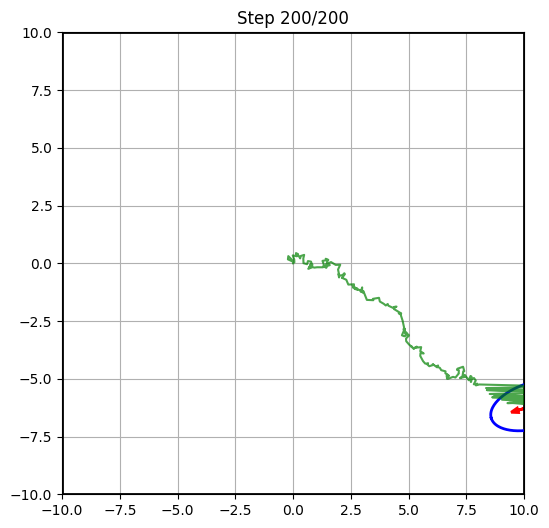

In [107]:

class BrownianSwimmer:
    """
    Represents a single oval (ellipse) that moves under Brownian-like dynamics,
    while leaving a trace of its position and respecting reflective boundaries.
    """

    def __init__(self, a=2.0, b=1.0,
                 x_init=0.0, y_init=0.0, theta_init=0.0,
                 U=1.0, D=0.01, n_points=200):
        self.a = a
        self.b = b
        self.x = x_init
        self.y = y_init
        self.theta = theta_init
        self.U = U
        self.D = D
        self.n_points = n_points

        # Precompute local shape (x', y') of the oval
        t = np.linspace(0, 2 * np.pi, n_points)
        self.x_prim = self.a * np.cos(t)
        self.y_prim = self.b * np.sin(t)

        # Store past trajectory
        self.trace_x = [self.x]
        self.trace_y = [self.y]

    def step(self, dt, xlim, ylim):
        """
        Update the position and orientation using Brownian increments,
        while ensuring the swimmer respects reflective boundary conditions.
        """
        xi1, xi2, xi3 = np.random.randn(3)

        # Tentative update of position
        new_x = self.x + (self.U * np.cos(self.theta) * dt
                          + np.sqrt(2*self.D*dt)*xi1)
        new_y = self.y + (self.U * np.sin(self.theta) * dt
                          + np.sqrt(2*self.D*dt)*xi2)
        new_theta = self.theta + np.sqrt(2*self.D*dt) * xi3

        # Get new extreme points
        (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom) = self.get_extreme_points(new_x, new_y, new_theta)

        x_min, x_max = xlim
        y_min, y_max = ylim

        # Reflective boundary conditions using extreme points
        if x_right > x_max:  # Right boundary
            new_x = 2*x_max - new_x
            new_theta = np.pi - new_theta  # Reflect in X direction
        elif x_left < x_min:  # Left boundary
            new_x = 2*x_min - new_x
            new_theta = np.pi - new_theta  # Reflect in X direction

        if y_top > y_max:  # Top boundary
            new_y = 2*y_max - new_y
            new_theta = -new_theta  # Reflect in Y direction
        elif y_bottom < y_min:  # Bottom boundary
            new_y = 2*y_min - new_y
            new_theta = -new_theta  # Reflect in Y direction

        # Apply updates
        self.x, self.y, self.theta = new_x, new_y, new_theta
        self.trace_x.append(self.x)
        self.trace_y.append(self.y)

    def get_global_coords(self):
        """
        Compute the global coordinates of the ellipse after rotation and translation.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)
        x_rot = c * self.x_prim - s * self.y_prim
        y_rot = s * self.x_prim + c * self.y_prim
        return x_rot + self.x, y_rot + self.y

    def get_extreme_points(self, x, y, theta):
        """
        Computes the four extreme points (leftmost, rightmost, topmost, bottommost)
        analytically for the rotated ellipse.
        """
        c, s = np.cos(theta), np.sin(theta)

        denom_x = np.sqrt(self.a**2 * c**2 + self.b**2 * s**2)
        x_right = x + denom_x
        x_left = x - denom_x
        y_right = y + ((self.a**2 - self.b**2) * s * c) / denom_x
        y_left = y - ((self.a**2 - self.b**2) * s * c) / denom_x

        denom_y = np.sqrt(self.a**2 * s**2 + self.b**2 * c**2)
        y_top = y + denom_y
        y_bottom = y - denom_y
        x_top = x + ((self.a**2 - self.b**2) * s * c) / denom_y
        x_bottom = x - ((self.a**2 - self.b**2) * s * c) / denom_y

        return (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom)

    def get_arrow_coords(self):
        """
        Computes the start and end points of an arrow representing the orientation.
        """
        arrow_length = 0.4 * self.a  # Arrow length scales with oval size
        x_end = self.x + arrow_length * np.cos(self.theta)
        y_end = self.y + arrow_length * np.sin(self.theta)
        return (self.x, self.y), (x_end, y_end)

    def run(self, steps=100, dt=0.1, xlim=(-5, 5), ylim=(-5, 5), pause_time=0.05):
        """
        Runs a live animation in a Jupyter Notebook, updating a single plot.
        Leaves a trace of the moving central point.
        """
        fig, ax = plt.subplots(figsize=(6, 6))

        for step_i in range(steps):
            self.step(dt, xlim, ylim)
            xg, yg = self.get_global_coords()
            (arrow_start, arrow_end) = self.get_arrow_coords()

            # Clear output and refresh plot
            clear_output(wait=True)
            ax.clear()

            # Draw boundary box
            ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
                    [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]],
                    'k-', lw=2)

            # Draw the oval
            ax.plot(xg, yg, 'b-', lw=2)
            ax.plot(self.trace_x, self.trace_y, 'g-', lw=1.5, alpha=0.7)  # Draw trajectory
            ax.plot(self.x, self.y, 'ro', ms=5)  # Mark center

            # Draw orientation arrow
            ax.arrow(arrow_start[0], arrow_start[1], 
                     arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                     head_width=0.2, head_length=0.3, fc='red', ec='red', lw=2)

            # Axes settings
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Step {step_i+1}/{steps}")
            ax.grid(True)

            display(fig)  # Show updated plot

        plt.close(fig)  # Close figure after animation completes

swimmer = BrownianSwimmer(a=2.0, b=1.0, U=1.0, D=0.1)
swimmer.run(steps=200, dt=0.05, xlim=(-10, 10), ylim=(-10, 10))


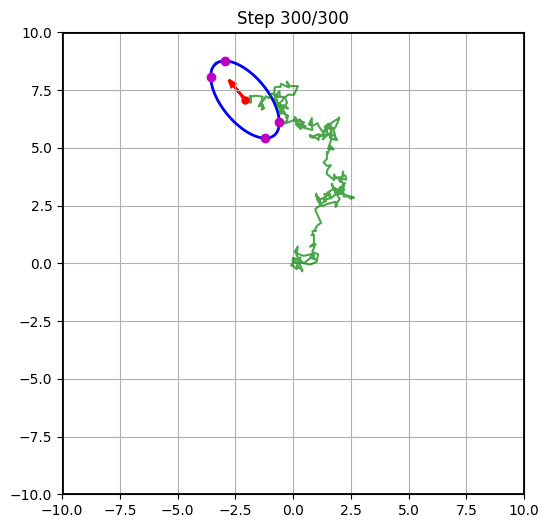

In [108]:

class BrownianSwimmer:
    """
    Represents a single oval (ellipse) that moves under Brownian-like dynamics,
    while leaving a trace of its position and respecting reflective boundaries.
    """

    def __init__(self, a=2.0, b=1.0,
                 x_init=0.0, y_init=0.0, theta_init=0.0,
                 U=1.0, D=0.01, n_points=200):
        self.a = a
        self.b = b
        self.x = x_init
        self.y = y_init
        self.theta = theta_init
        self.U = U
        self.D = D
        self.n_points = n_points

        # Precompute local shape (x', y') of the oval
        t = np.linspace(0, 2 * np.pi, n_points)
        self.x_prim = self.a * np.cos(t)
        self.y_prim = self.b * np.sin(t)

        # Store past trajectory
        self.trace_x = [self.x]
        self.trace_y = [self.y]

    def step(self, dt, xlim, ylim):
        """
        Update the position and orientation using Brownian increments,
        while ensuring the swimmer respects reflective boundary conditions.
        """
        xi1, xi2, xi3 = np.random.randn(3)

        # Tentative update of position
        new_x = self.x + (self.U * np.cos(self.theta) * dt
                          + np.sqrt(2*self.D*dt)*xi1)
        new_y = self.y + (self.U * np.sin(self.theta) * dt
                          + np.sqrt(2*self.D*dt)*xi2)
        new_theta = self.theta + np.sqrt(2*self.D*dt) * xi3

        # Get new extreme points
        (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom) = self.get_extreme_points(new_x, new_y, new_theta)

        x_min, x_max = xlim
        y_min, y_max = ylim
        correction_factor = 0  # Small offset to prevent immediate re-reflection

        # Reflective boundary conditions using extreme points
        if x_right > x_max:  # Right boundary
            print("right boundary violation")
            new_x = 2*x_max - new_x - correction_factor
            # new_theta = np.pi - new_theta  # Reflect in X direction
        elif x_left < x_min:  # Left boundary
            print("left boundary violation")
            new_x = 2*x_min - new_x + correction_factor
            # new_theta = np.pi - new_theta  # Reflect in X direction

        if y_top > y_max:  # Top boundary
            print("top boundary violation")
            new_y = 2*y_max - new_y - correction_factor
            # new_theta = -new_theta  # Reflect in Y direction
        elif y_bottom < y_min:  # Bottom boundary
            print("bottom boundary violation")
            new_y = 2*y_min - new_y + correction_factor
            # new_theta = -new_theta  # Reflect in Y direction

        # Apply updates
        self.x, self.y, self.theta = new_x, new_y, new_theta
        self.trace_x.append(self.x)
        self.trace_y.append(self.y)

    def get_global_coords(self):
        """
        Compute the global coordinates of the ellipse after rotation and translation.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)
        x_rot = c * self.x_prim - s * self.y_prim
        y_rot = s * self.x_prim + c * self.y_prim
        return x_rot + self.x, y_rot + self.y

    def get_extreme_points(self, x, y, theta):
        """
        Computes the four extreme points (leftmost, rightmost, topmost, bottommost)
        analytically for the rotated ellipse.
        """
        c, s = np.cos(theta), np.sin(theta)

        denom_x = np.sqrt(self.a**2 * c**2 + self.b**2 * s**2)
        x_right = x + denom_x
        x_left = x - denom_x
        y_right = y + ((self.a**2 - self.b**2) * s * c) / denom_x
        y_left = y - ((self.a**2 - self.b**2) * s * c) / denom_x

        denom_y = np.sqrt(self.a**2 * s**2 + self.b**2 * c**2)
        y_top = y + denom_y
        y_bottom = y - denom_y
        x_top = x + ((self.a**2 - self.b**2) * s * c) / denom_y
        x_bottom = x - ((self.a**2 - self.b**2) * s * c) / denom_y

        return (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom)

    def get_arrow_coords(self):
        """
        Computes the start and end points of an arrow representing the orientation.
        """
        arrow_length = 0.4 * self.a  # Arrow length scales with oval size
        x_end = self.x + arrow_length * np.cos(self.theta)
        y_end = self.y + arrow_length * np.sin(self.theta)
        return (self.x, self.y), (x_end, y_end)

    def run(self, steps=100, dt=0.1, xlim=(-5, 5), ylim=(-5, 5), pause_time=0.05):
        """
        Runs a live animation in a Jupyter Notebook, updating a single plot.
        Leaves a trace of the moving central point.
        """
        fig, ax = plt.subplots(figsize=(6, 6))

        for step_i in range(steps):
            self.step(dt, xlim, ylim)
            xg, yg = self.get_global_coords()
            (arrow_start, arrow_end) = self.get_arrow_coords()
            (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom) = self.get_extreme_points(self.x, self.y, self.theta)

            # Clear output and refresh plot
            clear_output(wait=True)
            ax.clear()

            # Draw boundary box
            ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
                    [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]],
                    'k-', lw=2)

            # Draw the oval
            ax.plot(xg, yg, 'b-', lw=2)
            ax.plot(self.trace_x, self.trace_y, 'g-', lw=1.5, alpha=0.7)  # Draw trajectory
            ax.plot(self.x, self.y, 'ro', ms=5)  # Mark center

            # Draw extreme points
            ax.plot([x_right, x_left, x_top, x_bottom],
                    [y_right, y_left, y_top, y_bottom],
                    'mo', ms=6, label="Extreme Points")

            # Draw orientation arrow
            ax.arrow(*arrow_start, arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                     head_width=0.2, head_length=0.3, fc='red', ec='red', lw=2)

            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Step {step_i+1}/{steps}")
            ax.grid(True)
            display(fig)

        plt.close(fig)


swimmer = BrownianSwimmer(a=2.0, b=1.0, U=1.0, D=0.2)
swimmer.run(steps=300, dt=0.05, xlim=(-10, 10), ylim=(-10, 10))


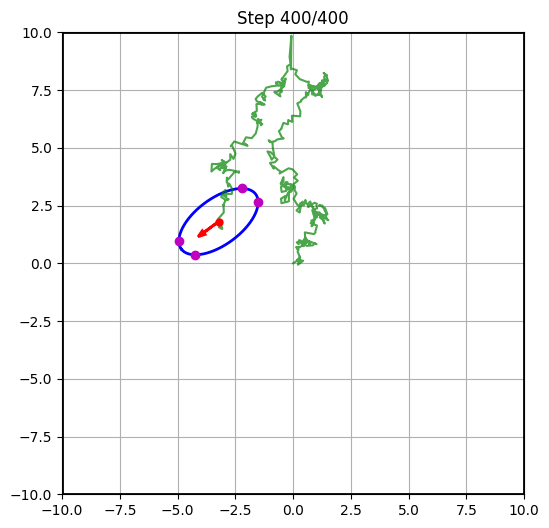

In [ ]:
class BrownianSwimmer:
    """
    Represents a single oval (ellipse) that moves under Brownian-like dynamics,
    while leaving a trace of its position and respecting reflective boundaries.
    """

    def __init__(self, a=2.0, b=1.0,
                 x_init=0.0, y_init=0.0, theta_init=0.0,
                 U=1.0, D=0.01, n_points=200):
        self.a = a
        self.b = b
        self.x = x_init
        self.y = y_init
        self.theta = theta_init
        self.U = U
        self.D = D
        self.n_points = n_points

        # Precompute local shape (x', y') of the oval
        t = np.linspace(0, 2 * np.pi, n_points)
        self.x_prim = self.a * np.cos(t)
        self.y_prim = self.b * np.sin(t)

        # Store past trajectory
        self.trace_x = [self.x]
        self.trace_y = [self.y]



    def step(self, dt, xlim, ylim):
        xi1, xi2, xi3 = np.random.randn(3)

        new_x = self.x + (self.U * np.cos(self.theta) * dt
                        + np.sqrt(2*self.D*dt)*xi1)
        new_y = self.y + (self.U * np.sin(self.theta) * dt
                        + np.sqrt(2*self.D*dt)*xi2)
        new_theta = self.theta + np.sqrt(2*self.D*dt)*xi3

        buffer = 1e-6  # Small buffer to prevent infinite loop
        max_attempts = 5  # Limit to prevent infinite reflections
        attempt = 0

        while attempt < max_attempts:
            (xr, yr), (xl, yl), (xt, yt), (xb, yb) = self.get_extreme_points(new_x, new_y, new_theta)

            x_min, x_max = xlim
            y_min, y_max = ylim
            corrected = False

            # Check x-bound
            if xr > x_max:
                new_x = x_max - (xr - x_max) - buffer  # Move slightly inside
                # new_theta = np.pi - new_theta
                corrected = True
            elif xl < x_min:
                new_x = x_min + (x_min - xl) + buffer
                # new_theta = np.pi - new_theta
                corrected = True

            # Check y-bound
            if yt > y_max:
                new_y = y_max - (yt - y_max) - buffer
                # new_theta = -new_theta
                corrected = True
            elif yb < y_min:
                new_y = y_min + (y_min - yb) + buffer
                # new_theta = -new_theta
                corrected = True

            if not corrected:
                break  # Exit if no more reflections needed

            attempt += 1  # Prevent infinite loop

        # Once inside, accept
        self.x, self.y, self.theta = new_x, new_y, new_theta
        self.trace_x.append(self.x)
        self.trace_y.append(self.y)



    def get_global_coords(self):
        """
        Compute the global coordinates of the ellipse after rotation and translation.
        """
        c, s = np.cos(self.theta), np.sin(self.theta)
        x_rot = c * self.x_prim - s * self.y_prim
        y_rot = s * self.x_prim + c * self.y_prim
        return x_rot + self.x, y_rot + self.y

    def get_extreme_points(self, x, y, theta):
        """
        Computes the four extreme points (leftmost, rightmost, topmost, bottommost)
        analytically for the rotated ellipse.
        """
        c, s = np.cos(theta), np.sin(theta)

        denom_x = np.sqrt(self.a**2 * c**2 + self.b**2 * s**2)
        x_right = x + denom_x
        x_left = x - denom_x
        y_right = y + ((self.a**2 - self.b**2) * s * c) / denom_x
        y_left = y - ((self.a**2 - self.b**2) * s * c) / denom_x

        denom_y = np.sqrt(self.a**2 * s**2 + self.b**2 * c**2)
        y_top = y + denom_y
        y_bottom = y - denom_y
        x_top = x + ((self.a**2 - self.b**2) * s * c) / denom_y
        x_bottom = x - ((self.a**2 - self.b**2) * s * c) / denom_y

        return (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom)

    def get_arrow_coords(self):
        """
        Computes the start and end points of an arrow representing the orientation.
        """
        arrow_length = 0.4 * self.a  # Arrow length scales with oval size
        x_end = self.x + arrow_length * np.cos(self.theta)
        y_end = self.y + arrow_length * np.sin(self.theta)
        return (self.x, self.y), (x_end, y_end)

    def run(self, steps=100, dt=0.1, xlim=(-5, 5), ylim=(-5, 5), pause_time=0.05):
        """
        Runs a live animation in a Jupyter Notebook, updating a single plot.
        Leaves a trace of the moving central point.
        """
        fig, ax = plt.subplots(figsize=(6, 6))

        for step_i in range(steps):
            self.step(dt, xlim, ylim)
            xg, yg = self.get_global_coords()
            (arrow_start, arrow_end) = self.get_arrow_coords()
            (x_right, y_right), (x_left, y_left), (x_top, y_top), (x_bottom, y_bottom) = self.get_extreme_points(self.x, self.y, self.theta)

            # Clear output and refresh plot
            clear_output(wait=True)
            ax.clear()

            # Draw boundary box
            ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
                    [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]],
                    'k-', lw=2)

            # Draw the oval
            ax.plot(xg, yg, 'b-', lw=2)
            ax.plot(self.trace_x, self.trace_y, 'g-', lw=1.5, alpha=0.7)  # Draw trajectory
            ax.plot(self.x, self.y, 'ro', ms=5)  # Mark center

            # Draw extreme points
            ax.plot([x_right, x_left, x_top, x_bottom],
                    [y_right, y_left, y_top, y_bottom],
                    'mo', ms=6, label="Extreme Points")

            # Draw orientation arrow
            ax.arrow(*arrow_start, arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                     head_width=0.2, head_length=0.3, fc='red', ec='red', lw=2)

            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Step {step_i+1}/{steps}")
            ax.grid(True)
            display(fig)

        plt.close(fig)


swimmer = BrownianSwimmer(a=2, b=1.0, U=1.0, D=0.2)
swimmer.run(steps=400, dt=0.05, xlim=(-10, 10), ylim=(-10, 10))


For a given 